In [296]:
# Initialize Otter
import otter
grader = otter.Notebook("check_inverse_kinematics.ipynb")

# Arm inverse kinematics

Do IK twice, once with gradient descent, once with a Jacobian.
All the code is in arm_ik_gradient.py and arm_ik_jacobian.py

**Files to include:**
- matrix_transforms.py
- objects_in_world.py
- arm_forward_kinematics.py
- arm_ik_jacobian.py
- arm_ik_gradient.py

Slides: https://docs.google.com/presentation/d/1dowamZVQqyLDZ-k-vWRV0rrQ-4dMVWhSCy25BV8a6bU/edit?usp=sharing

In [297]:
# Doing the imports for you
import numpy as np
import json as json
import matplotlib.pyplot as plt

In [298]:
import sys; 
sys.path.insert(0, '.')
sys.path.insert(0, '../Skills')

# These commands will force JN to actually re-load the external file when you re-execute the import command
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [299]:
import arm_forward_kinematics as afk
import arm_ik_gradient as ik_gradient

## Checking that all the .py files are included properly
And that the data files read properly

- matrix_tranforms,py
- objects_in_world.py
- arm_forward_kinematics.py
- arm_ik_gradient.py
- arm_jacobian_gradient.py

We include these for you
- Data/Wedge.json 
- Data/Square.json

There is nothing you need to do here, except make sure the .py files are included

In [300]:
import matrix_transforms as mt
import objects_in_world as obj_in_world
import arm_ik_jacobian as ik_jacobian

In [301]:
grader.check("included_all_files")

included_all_files results:
    included_all_files - 1 result:
        ✅ Test case passed

    included_all_files - 2 result:
        ✅ Test case passed

    included_all_files - 3 result:
        ✅ Test case passed

    included_all_files - 4 result:
        ✅ Test case passed

    included_all_files - 5 result:
        ✅ Test case passed

    included_all_files - 6 result:
        ✅ Test case passed

    included_all_files - 7 result:
        ❌ Test case failed
        Trying:
            ang = ik_jacobian.practice_jacobian()
        Expecting nothing
        **********************************************************************
        Line 1, in included_all_files 6
        Failed example:
            ang = ik_jacobian.practice_jacobian()
        Expected nothing
        Got:
            (array([[-0.03200665]]), array([0.00088017]), np.int32(1), array([3.]))
            [[-0.01]
             [-0.1 ]]
            [ 0.01907622 -0.09410596]
            Delta angle [-0.03200665], should be -0.32
            New point and moved point should be the close to the same
            Old point: [np.float64(2.940199733523725), np.float64(0.5960079923851836)]
            New pt: [np.float64(2.9301997335237253), np.float64(0.49600799238518367)]
            Moved pt: [np.float64(2.9577668188511104), np.float64(0.5016128440374932)]

## Gradient calculation, using distance of grasp point to target
There are tests for each step of this/each function to make sure that you're getting the correct (or same as the example code) values. 

In [302]:
# Create the arm geometry
base_size_param = (1.0, 0.5)
link_sizes_param = [(0.5, 0.25), (0.3, 0.1), (0.2, 0.05)]
palm_width_param = 0.1
finger_size_param = (0.075, 0.025)

arm_geometry = afk.create_arm_geometry(base_size_param, link_sizes_param, palm_width_param, finger_size_param)

# Set some initial angles
angles_check = [0.0, np.pi/4, 0, [-np.pi/4.0, np.pi/4.0, -np.pi/4.0]]
afk.set_angles_of_arm_geometry(arm_geometry, angles_check)

In [303]:
# First check - do you get the same answer for the gripper location?
gripper_loc = afk.get_gripper_location(arm_geometry)
exp_gripper_loc = (-0.3536, 1.4098)
if not np.isclose(gripper_loc[0], exp_gripper_loc[0], atol=0.01) or not np.isclose(gripper_loc[1], exp_gripper_loc[1], atol=0.01):
    print(f"Gripper loc, expected {exp_gripper_loc}, got {gripper_loc}")
else:
    print(f"Success: got same gripper location")


Success: got same gripper location


In [304]:
# Set the target for the example here
target = (0.5, 1.5)

Text(0.5, 1.0, 'Before gradient descent')

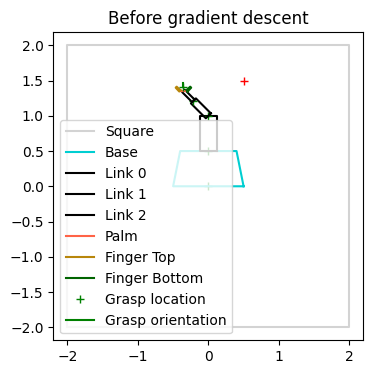

In [305]:
# Plot so you can see what the arm angles produce and where the target is
fig, axs = plt.subplots(1, 1, figsize=(4, 4))

# Actually get the matrices
matrices = afk.get_matrices_all_links(arm_geometry)
afk.plot_complete_arm(axs, arm_geometry, matrices)

# Plot target too
axs.plot(target[0], target[1], '+r')
axs.set_title("Before gradient descent")

In [306]:
# First check - vector to goal - see pic above, should point from green + to red one
vec = ik_gradient.vector_to_goal(arm_geometry, target)
if not vec.shape[0] == 2:
    print(f"Expected a 2x1 vector, got {vec.shape}")
elif not np.isclose(vec[0], 0.8535, atol=0.01) or not np.isclose(vec[1], 0.09019, atol=0.01):
    print(f"Expected (0.853, 0.090), got {vec}")
else:
    print("Passed vec check")

Passed vec check


In [307]:
# Second check - distance to goal, should be length of vector
dist_to_arm = ik_gradient.distance_to_goal(arm_geometry, target)
if not np.isclose(dist_to_arm, 0.858, atol=0.01):
    print(f"Expected 0.858, got {dist_to_arm:0.3}")
else:
    print(f"Passed distance check, dist {dist_to_arm:0.3}")

Passed distance check, dist 0.858


In [308]:
# Third check - the gradient. 
grad = ik_gradient.calculate_gradient(arm_geometry, angles_check, target)
exp_grad = [0.9419, 0.4447, 0.2114, 0.0559]
if not len(grad) == 4:
    print(f"Expected a 4x1 list, got {grad}")
elif not np.all(np.isclose(grad, exp_grad, atol=0.01)):
    print(f"Expected {exp_grad} got {grad}")
else:
    print("Passed gradient check")

Passed gradient check


In [309]:
grader.check("gradient_calculation")

gradient_calculation results: All test cases passed!

## Gradient descent
This checks the actual gradient descent algorithm - does the gripper get closer to the goal at each time step? Does it eventually reach the goal?

Checks gradient_descent in arm_ik_gradient.py

In [310]:

# Main check - do we get out the new angles? Note, this assumes that you haven't changed up the step size
b_succ, angles_new, count = ik_gradient.gradient_descent(arm_geometry, angles_check, target, b_one_step=True)
ang_exp = [-0.942, 0.341, -0.211, [-0.841, 0, 0]]
if not len(angles_new) == 4:
    print(f"Expected {ang_exp}, got {angles_new}")
for a1, a2 in zip(angles_new, ang_exp):
    if not np.all(np.isclose(a1, a2, atol=0.01)):
        print(f"Expected {a2} got {a1}")
if not b_succ:
    print(f"Expected successful/improvement, got none")

In [311]:
# This will actually change the arm geometry based on the new angles
afk.set_angles_of_arm_geometry(arm_geometry, angles_check)
last_dist = ik_gradient.distance_to_goal(arm_geometry, target)

# For first round of for loop
angles_new = angles_check
print(f"Starting distance {last_dist}")
for i in range(0, 3):
    b_succ, angles_new, count = ik_gradient.gradient_descent(arm_geometry, angles_new, target, b_one_step=True)
    afk.set_angles_of_arm_geometry(arm_geometry, angles_new)
    dist = ik_gradient.distance_to_goal(arm_geometry, target)
    if not b_succ:
        print(f"Expected successful/improvement after each iteration, got none")
    elif not dist < last_dist:
        print(f"Expected improvement, got none, dist {dist}")
    else:
        print(f"Passed iteration check {i}, dist {dist}")
    last_dist = dist

if not np.isclose(dist, 0.1, atol=0.01):
    print(f"Expected distance to be close to 0.1, got {dist}, count {count}")


Starting distance 0.8583057840546942
Passed iteration check 0, dist 0.4264293217900865
Passed iteration check 1, dist 0.3245522611038239
Passed iteration check 2, dist 0.10734186274289183


In [312]:
# Do gradient descent until gradient descent bottoms out
b_succ, angles_new, count = ik_gradient.gradient_descent(arm_geometry, angles_check, target, b_one_step=False)

# Set the new angles
afk.set_angles_of_arm_geometry(arm_geometry, angles_new)
dist = ik_gradient.distance_to_goal(arm_geometry, target)

if not b_succ:
    print(f"Expected successful/improvement, got none")
elif not np.isclose(dist, 0.063, atol=0.01):
    print(f"Expected distance to be close to 0.063, got {dist}, count {count}")
    
else:
    print(f"Passed full descent {dist:0.2}")

Passed full descent 0.063


Text(0.5, 1.0, 'After gradient descent count 1001 dist 0.0633')

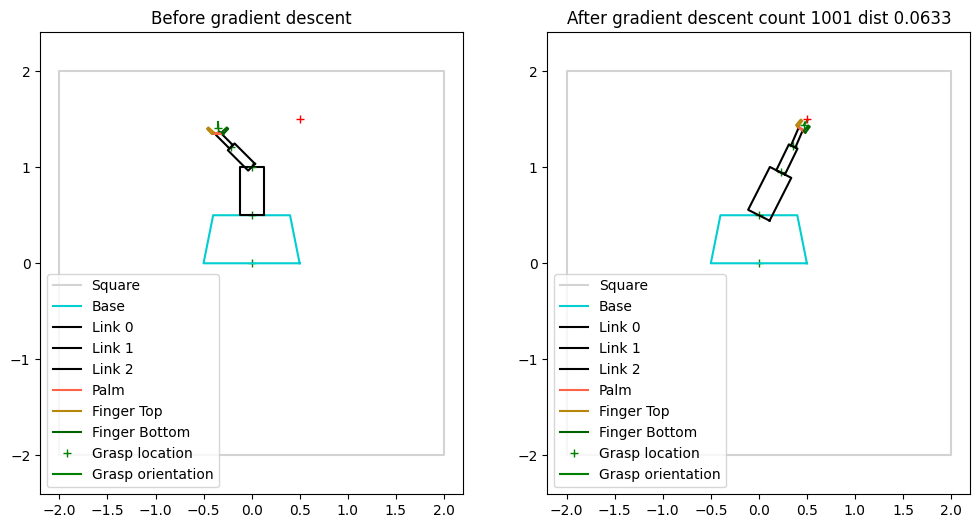

In [313]:
# And plot the old and the new
# Plot so you can see what it should look like
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, a in enumerate([angles_check, angles_new]):
    # Actually get the matrices
    afk.set_angles_of_arm_geometry(arm_geometry, a)
    matrices = afk.get_matrices_all_links(arm_geometry)
    afk.plot_complete_arm(axs[i], arm_geometry, matrices)

    # Plot target too
    axs[i].plot(target[0], target[1], '+r')

axs[0].set_title("Before gradient descent")
axs[1].set_title(f"After gradient descent count {count} dist {dist:0.3}")

In [314]:
grader.check("gradient_descent")

gradient_descent results:
    gradient_descent - 1 result:
        ❌ Test case failed
        Trying:
            from tests_ik_autograder import test_reach_target
        Expecting nothing
        **********************************************************************
        Line 1, in gradient_descent 0
        Failed example:
            from tests_ik_autograder import test_reach_target
        Exception raised:
            Traceback (most recent call last):
              File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest gradient_descent 0[0]>", line 1, in <module>
                from tests_ik_autograder import test_reach_target
              File "/Users/ghostleader320/Documents/GitHub/ROB514/RobotArm2D/tests_ik_autograder.py", line 9, in <module>
                import RobotArm2D.arm_ik_gradient as ik_gradient
            ModuleNotFoundError: No module named 'RobotArm2D'
        Trying:
            assert test_reach_target(ik_gradient.gradient_descent)
        Expecting nothing
        **********************************************************************
        Line 2, in gradient_descent 0
        Failed example:
            assert test_reach_target(ik_gradient.gradient_descent)
        Exception raised:
            Traceback (most recent call last):
              File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest gradient_descent 0[1]>", line 1, in <module>
                assert test_reach_target(ik_gradient.gradient_descent)
                       ^^^^^^^^^^^^^^^^^
            NameError: name 'test_reach_target' is not defined

# IK using a jacobian
You can do either the Jacobian numerically or from matrices (extra credit) or both. 
The routines you need to edit are in arm_ik_jacobian.py

## Practice Jacobian
This is a 1d, stand-alone Jacobian. 

In [315]:
import arm_ik_jacobian as ik_jacobian

In [316]:
# Do this first to make sure you know how to calculate a Jacobian for 1 link
#  There's additional prints that print out the angle, moved point, etc.
print("Checking practice jacobian")
ang = ik_jacobian.practice_jacobian()
exp_ang = -0.032
try:
    if not np.isclose(ang, exp_ang, atol=0.01):
        print(f"Practice jacobian: Expected {exp_ang}, got {ang}")
    else:
        print(f"Passed practice jacobian test")
except:
    print(f"Probably an indexing/data structure problem Expected {exp_ang}, got {ang}\n")

Checking practice jacobian
(array([[-0.03200665]]), array([0.00088017]), np.int32(1), array([3.]))
[[-0.01]
 [-0.1 ]]
[ 0.01907622 -0.09410596]
Delta angle [-0.03200665], should be -0.32
New point and moved point should be the close to the same
Old point: [np.float64(2.940199733523725), np.float64(0.5960079923851836)]
New pt: [np.float64(2.9301997335237253), np.float64(0.49600799238518367)]
Moved pt: [np.float64(2.9577668188511104), np.float64(0.5016128440374932)]
Passed practice jacobian test


In [317]:
grader.check("practice_jacobian")

practice_jacobian results: All test cases passed!

## Calculate jacobian
You need to do one of calculate_jacobian_numerically or calculate_jacobian (from matrices). Doing both will win you prizes and acclaim (and extra credit)

In [318]:

# Create the arm geometry
base_size_param = (1.0, 0.5)
link_sizes_param = [(0.5, 0.25), (0.3, 0.1), (0.2, 0.05)]
palm_width_param = 0.1
finger_size_param = (0.075, 0.025)

arm_geometry = afk.create_arm_geometry(base_size_param, link_sizes_param, palm_width_param, finger_size_param)

# Set some initial angles
angles_check = [0.0, np.pi/4, 0, [-np.pi/4.0, np.pi/4.0, -np.pi/4.0]]
afk.set_angles_of_arm_geometry(arm_geometry, angles_check)

# The location to reach for
target = (0.5, 1.5)

In [319]:
### Numerical calculation check

In [320]:
# First check - calculating the jacobian (2 x 4 matrix) calculated numerically
jacob_numerical = ik_jacobian.calculate_jacobian_numerically(arm_geometry, angles_check)
exp_jacob = np.array([[-0.9098, -0.4098, -0.1977, -0.0562], [-0.3535, -0.3535, -0.1414, 0.0]])
if not np.all(np.isclose(jacob_numerical, exp_jacob, atol=0.01)):
    print(f"Expected jacob\n{exp_jacob}, got\n{jacob}\n{np.isclose(jacob, exp_jacob, atol=0.01)}")
else:
    print("Passed numerical jacob test")

Passed numerical jacob test


In [321]:
### Matrix calculation check

In [322]:
# # Second check (optional) - calculating the jacobian using matrices (2 x 4 matrix)
# jacob_matrix = ik_jacobian.calculate_jacobian(arm_geometry, angles_check)
# if not np.all(np.isclose(jacob_matrix, exp_jacob, atol=0.01)):
#     print(f"Expected jacob\n{exp_jacob}, got\n{jacob}\n{np.isclose(jacob, exp_jacob, atol=0.01)}")
# else:
#     print("Passed matrix jacob test")

In [323]:
grader.check("jacobian")

jacobian results: All test cases passed!

## Do the pseudo inverse
Do the pseudo inverse (solve_jacobian) to solve for a set of angle changes given a set of x,y changes

In [324]:
# Third check - pseudo inverse 1 x 5 matrix of angle changes needed to get the desired x,y change
delta_angles = ik_jacobian.solve_jacobian(np.array(exp_jacob), np.array([0.5, -0.2]))
exp_delta_angles = np.array([-1.456, 1.819,  0.506, -0.368])
if not np.all(np.isclose(delta_angles, exp_delta_angles, atol=0.01)):
    print(f"Expected delta angles\n{exp_delta_angles}, got\n{delta_angles}")
else:
    print("Passed solve jacobian test")

Passed solve jacobian test


In [325]:
grader.check("solve_jacobian")

solve_jacobian results: All test cases passed!

## Use the Jacobian to move the gripper closer to the goal
Edit the code in jacobian_descent (which is very similar to gradient_descent). The checks *should* work with either the numerical or matrix jacobian.

In [326]:
# Main check - do we get out the new angles? Note, this assumes that you haven't changed up the step size
b_succ, angles_new, count = ik_jacobian.jacobian_follow_path(arm_geometry, angles_check, target, b_one_step=True)
ang_exp = [-0.0864, 0.8506, 0.01585, [-0.8024, 0, 0]]
if not len(angles_new) == 4:
    print(f"Expected {ang_exp}, got {angles_new}")
for a1, a2 in zip(angles_new, ang_exp):
    if not np.all(np.isclose(a1, a2, atol=0.01)):
        print(f"Expected {a2} got {a1}")
if not b_succ:
    print(f"Expected successful/improvement, got none")

In [327]:
b_succ, angles_new, count = ik_jacobian.jacobian_follow_path(arm_geometry, angles_check, target, b_one_step=False)
afk.set_angles_of_arm_geometry(arm_geometry, angles_new)
dist = ik_gradient.distance_to_goal(arm_geometry, target)
if not b_succ:
    print(f"Expected successful/improvement, got none")
elif not np.isclose(dist, 0.062, atol=0.01):
    print(f"Expected distance to be close to 0.063, got {dist}, count {count}")
else: 
    print(f"Passed full solve check, dist {dist:0.2}")

Passed full solve check, dist 0.063


Text(0.5, 1.0, 'After Jacobian descent count 32 dist 0.063')

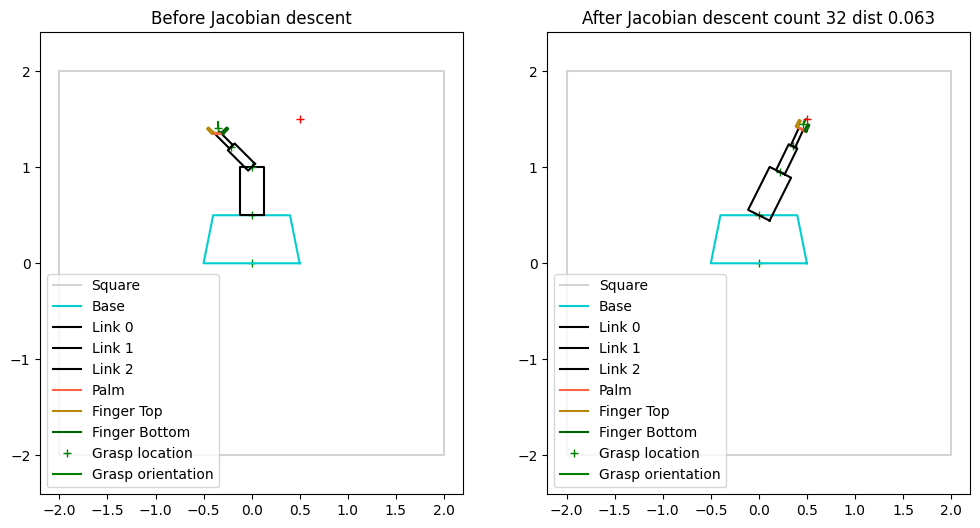

In [328]:
# Plot so you can see what it should look like
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, a in enumerate([angles_check, angles_new]):
    # Actually get the matrices
    afk.set_angles_of_arm_geometry(arm_geometry, a)
    matrices = afk.get_matrices_all_links(arm_geometry)
    afk.plot_complete_arm(axs[i], arm_geometry, matrices)

    # Plot target too
    axs[i].plot(target[0], target[1], '+r')

axs[0].set_title("Before Jacobian descent")
axs[1].set_title(f"After Jacobian descent count {count} dist {dist:0.2}")

In [329]:
grader.check("jacobian_descent")

jacobian_descent results:
    jacobian_descent - 1 result:
        ❌ Test case failed
        Trying:
            from tests_ik_autograder import test_reach_target
        Expecting nothing
        **********************************************************************
        Line 1, in jacobian_descent 0
        Failed example:
            from tests_ik_autograder import test_reach_target
        Exception raised:
            Traceback (most recent call last):
              File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest jacobian_descent 0[0]>", line 1, in <module>
                from tests_ik_autograder import test_reach_target
              File "/Users/ghostleader320/Documents/GitHub/ROB514/RobotArm2D/tests_ik_autograder.py", line 9, in <module>
                import RobotArm2D.arm_ik_gradient as ik_gradient
            ModuleNotFoundError: No module named 'RobotArm2D'
        Trying:
            assert test_reach_target(ik_jacobian.jacobian_follow_path)
        Expecting nothing
        **********************************************************************
        Line 2, in jacobian_descent 0
        Failed example:
            assert test_reach_target(ik_jacobian.jacobian_follow_path)
        Exception raised:
            Traceback (most recent call last):
              File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest jacobian_descent 0[1]>", line 1, in <module>
                assert test_reach_target(ik_jacobian.jacobian_follow_path)
                       ^^^^^^^^^^^^^^^^^
            NameError: name 'test_reach_target' is not defined

## Hours and collaborators
Required for every assignment - fill out before you hand-in.

Listing names and websites helps you to document who you worked with and what internet help you received in the case of any plagiarism issues. You should list names of anyone (in class or not) who has substantially helped you with an assignment - or anyone you have *helped*. You do not need to list TAs.

Listing hours helps us track if the assignments are too long.

In [330]:

# List of names (creates a set)
worked_with_names = {"mindy atuschul","liv dawes","liam bouffard"}
# List of URLS FW25(creates a set)
websites = {"not filled out"}
# Approximate number of hours, including lab/in-class time
hours = 5

In [331]:
grader.check("hours_collaborators")

hours_collaborators results:
    hours_collaborators - 1 result:
        ✅ Test case passed

    hours_collaborators - 2 result:
        ❌ Test case failed
        Trying:
            assert not 'not filled out' in websites
        Expecting nothing
        **********************************************************************
        Line 1, in hours_collaborators 1
        Failed example:
            assert not 'not filled out' in websites
        Exception raised:
            Traceback (most recent call last):
              File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest hours_collaborators 1[0]>", line 1, in <module>
                assert not 'not filled out' in websites
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError

    hours_collaborators - 3 result:
        ✅ Test case passed